In [1]:

import pandas as pd
import numpy as np

import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
def market_value(position, price):
    return position * price

def net_asset_value(market_values, cash):
    return cash + market_values.sum(axis=1)

def gross_exposure(market_values, nav):
    return market_values.abs().sum(axis=1).div(nav)

def net_exposure(market_values,nav):
    return market_values.sum(axis=1).div(nav) 

def net_beta_exposure(market_values, beta, nav):
    beta_weighted_mv = market_values.mul(beta)
    return beta_weighted_mv.sum(axis=1).div(nav)

## Portfolio Valuation & Exposure Functions

These functions calculate key portfolio metrics used in dynamic risk management and position sizing.

### 1. Market Value
$$\text{MV}_i = \text{Position}_i \times \text{Price}_i$$

Computes the market value of each position by multiplying shares held by their current price. For a multi-asset portfolio, returns a series where each element is the dollar value of that position.

### 2. Net Asset Value (NAV)
$$\text{NAV}_t = \text{Cash}_t + \sum_{i=1}^{n} \text{MV}_{i,t}$$

Total portfolio value equals cash on hand plus the sum of all position market values. This is the denominator for all exposure ratios.

### 3. Gross Exposure
$$\text{Gross Exposure}_t = \frac{\sum_{i=1}^{n} |\text{MV}_{i,t}|}{\text{NAV}_t}$$

Measures total leverage by summing absolute values of all positions (long and short treated equally) divided by NAV. Values > 1 indicate leverage; = 1 indicates fully invested; < 1 indicates underutilized capital.

**Example:** Portfolio with $100K NAV, $60K long, $40K short → Gross Exposure = $100K / $100K = 1.0

### 4. Net Exposure
$$\text{Net Exposure}_t = \frac{\sum_{i=1}^{n} \text{MV}_{i,t}}{\text{NAV}_t}$$

Measures directional bias by summing signed position values (long positive, short negative) divided by NAV. Range: [-1, 1].

**Example:** Same portfolio → Net Exposure = ($60K - $40K) / $100K = 0.2 (20% net long)

### 5. Net Beta-Weighted Exposure
$$\text{Net Beta Exposure}_t = \frac{\sum_{i=1}^{n} \beta_i \times \text{MV}_{i,t}}{\text{NAV}_t}$$

Adjusts net exposure for each position's systematic risk (beta). Positions with high beta contribute more to portfolio market sensitivity, even if dollar values are equal.

**Use Case:** Market-neutral strategies use this to maintain $\approx 0$ net beta exposure while maintaining specific long/short positions.

In [3]:
def risk_appetite(equity_curve, max_drawdown_tolerance, 
                           min_risk, max_risk, 
                           smoothing_span=20, 
                           curve_shape='linear',
                           drawdown_window=0):
    """
    curve_shape : {'linear', 'aggressive', 'conservative'}, default='linear'
        'aggressive': Scale up quickly when recovering (convex < 1)
        'conservative': Scale up slowly when recovering (concave > 1)
        'linear': Proportional response
    """
    equity = pd.Series(equity_curve)
    
    if drawdown_window > 0:
        running_max = equity.rolling(window=drawdown_window, min_periods=1).max()        
    else:
        running_max = equity.expanding().max()  # All-time high
    
    drawdown = equity / running_max - 1    
    normalized = 1 - np.minimum(drawdown / max_drawdown_tolerance, 1)
    smoothed = normalized.ewm(span=smoothing_span).mean()    
    # mapping: convex (<1 aggressive), concave (>1 conservative)
    power_map = {'aggressive': min_risk / max_risk, 'conservative': max_risk / min_risk, 'linear': 1}
    power = power_map.get(curve_shape, 1)
    transformed = smoothed ** power    
    risk_appetite = min_risk + (max_risk - min_risk) * transformed
    
    return risk_appetite

## Dynamic Risk Appetite Function

**Objective:**
Dynamically adjust portfolio risk allocation based on current drawdown. The function scales risk between minimum and maximum thresholds, reducing exposure during drawdowns and increasing it near equity peaks.

**Step-by-Step Process:**

1. **Calculate Drawdown**: Compute percentage decline from peak equity
   - Uses expanding window (all-time high) by default
   - Optional rolling window for shorter-term drawdown measurement
   
2. **Normalize Drawdown**: Scale drawdown relative to maximum tolerance
   - Converts absolute drawdown to 0-1 range
   - 0 = at maximum drawdown tolerance (minimum risk)
   - 1 = at peak equity (maximum risk)

3. **Smooth the Signal**: Apply exponential moving average
   - Reduces noise and prevents rapid risk changes
   - Default 20-period smoothing span

4. **Apply Response Curve**: Transform normalized drawdown based on risk preference
   - **Linear**: Proportional response (risk scales linearly with drawdown)
   - **Convex**: Aggressive recovery (risk increases quickly as drawdown improves)
   - **Concave**: Conservative recovery (risk increases slowly, stays defensive longer)

5. **Scale to Risk Range**: Map transformed value to actual risk allocation
   - Interpolates between min_risk and max_risk
   - Returns final risk appetite as decimal (e.g., 0.05 for 5%)

**Result:**
Returns a pandas Series of risk appetite values between `min_risk` and `max_risk`, inversely correlated with portfolio drawdown. Higher values near equity peaks, lower values during drawdowns.

In [4]:
def simulate_equity_curve(initial_capital, annual_return, annual_vol, days, dt=1/252, seed=42):
    """    
    dS = μ*S*dt + σ*S*dW    
    """
    np.random.seed(seed)       
    mu = annual_return * dt 
    sigma = annual_vol * np.sqrt(dt) 
    equity = np.zeros(days)
    equity[0] = initial_capital
    
    # Euler scheme: S(t+dt) = S(t) * (1 + mu*dt + sigma*dW)
    for t in range(1, days):
        dW = np.random.normal(0, 1) 
        equity[t] = equity[t-1] * (1 + mu + sigma * dW)    
    return equity

## GBM Euler Simulator

- Purpose: Simulate an equity path for strategy/risk testing
- Inputs: `initial_capital`, `annual_return`, `annual_vol`, `days`, `dt=1/252`, `seed`
- Method: Daily update with Euler GBM
  - `μ = annual_return * dt`, `σ = annual_vol * sqrt(dt)`
  - `equity[t] = equity[t-1] * (1 + μ + σ * dW)` with `dW ~ N(0,1)`
- Output: NumPy array of length `days` (equity curve)
- Notes: Set `seed` for reproducibility; keep `dt=1/252` for daily

In [5]:
# Simulate multiple scenarios
np.random.seed(42)
initial_cap = 1_000_000
annual_ret = 0.12  # 12% return
annual_volatility = 0.18  # 18% volatility
num_days = 252 * 3  # 3 years

# Generate 3 different scenarios with different random seeds
scenarios = {}
for scenario_id in range(1, 4):
    equity_sim = simulate_equity_curve(
        initial_capital=initial_cap,
        annual_return=annual_ret,
        annual_vol=annual_volatility,
        days=num_days,
        seed=scenario_id * 100
    )
    scenarios[f'Scenario {scenario_id}'] = equity_sim

## Scenario Risk Appetite Plots


**Objective:** Visualize how linear, convex, and concave risk-appetite curves respond to drawdowns across three simulated GBM equity paths (same drift/vol, different seeds).


**Step-by-step:**

1) Simulate three 3-year equity paths via Euler GBM (initial_cap, annual_ret, annual_vol, dt=1/252, distinct seeds).

2) Set risk parameters: max drawdown tolerance = -annual_volatility * 0.4, min risk = 2%, max risk = 10%, smoothing span = 20, drawdown_window = 126.

3) For each scenario: plot equity with fill + initial-cap line; compute risk appetite for each shape via `risk_appetite`; plot % risk with markers every 50 points, colored by shape.

4) Add min/max risk bands, grid, legends; arrange 1×2: equity (left), risk appetite (right).



**Result:** One figure per scenario showing the equity path and three risk-allocation curves bounded by min/max lines, highlighting how curve shape changes scaling during drawdown/recovery phases.


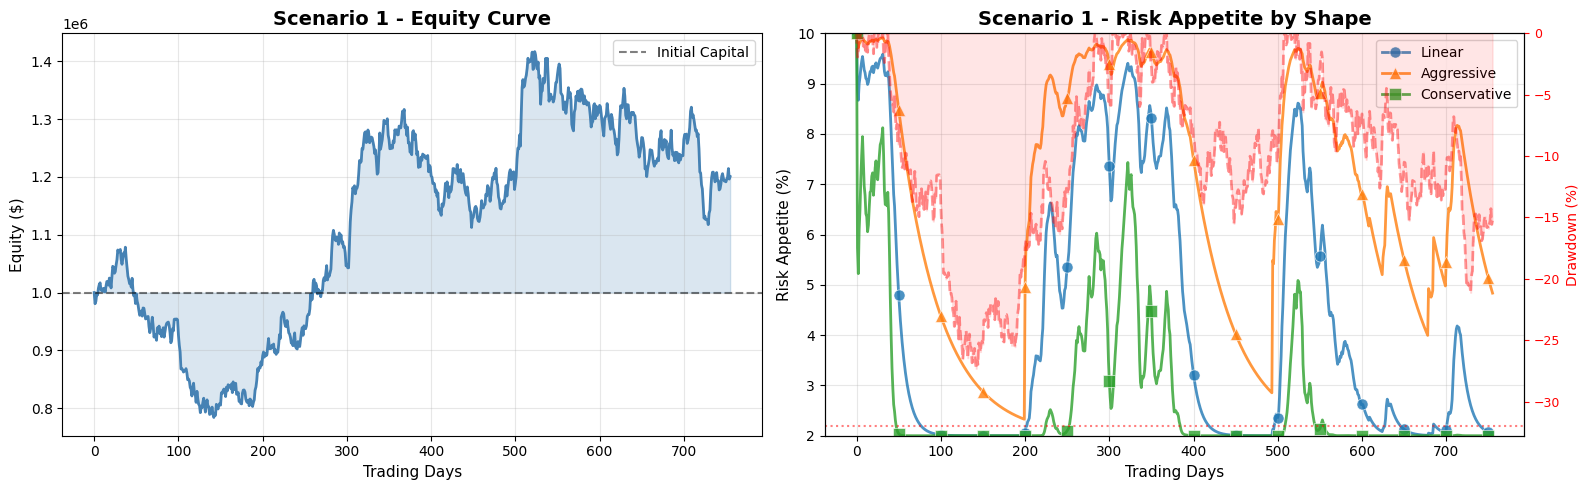

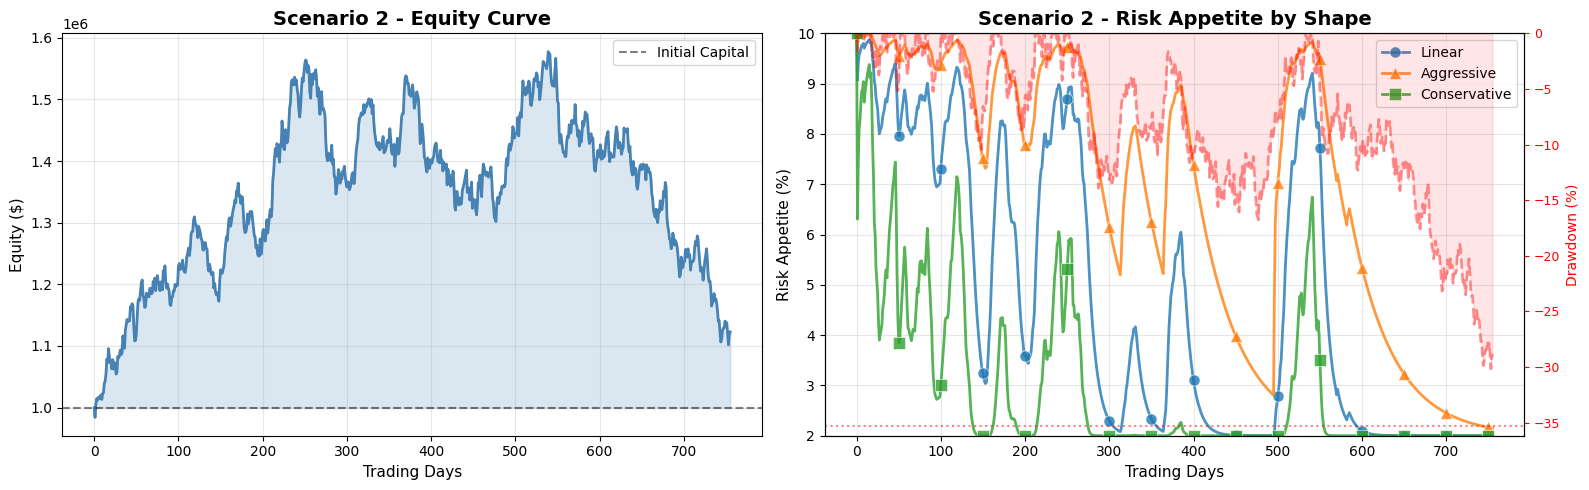

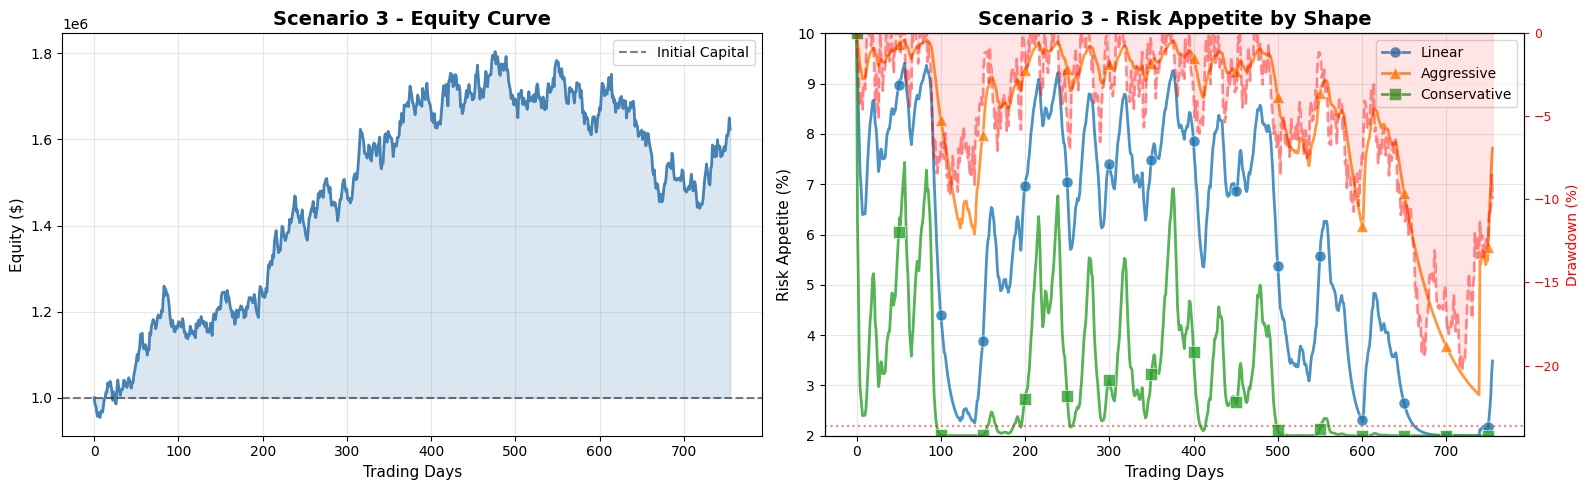

In [6]:
# Calculate risk appetite for each scenario with different curve shapes
max_dd_tol = -annual_volatility * 0.4  
min_risk_val = 0.02  # 2% minimum risk
max_risk_val = 0.10  # 10% maximum risk

# Create separate figure for each scenario
for scenario_name, equity_path in scenarios.items():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Left: Equity curve
    ax_equity = axes[0]
    ax_equity.plot(equity_path, linewidth=2, color='steelblue')
    ax_equity.fill_between(range(len(equity_path)), initial_cap, equity_path, alpha=0.2, color='steelblue')
    ax_equity.axhline(y=initial_cap, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
    ax_equity.set_title(f'{scenario_name} - Equity Curve', fontsize=14, fontweight='bold')
    ax_equity.set_ylabel('Equity ($)', fontsize=11)
    ax_equity.set_xlabel('Trading Days', fontsize=11)
    ax_equity.grid(True, alpha=0.3)
    ax_equity.legend(fontsize=10)
    
    # Right: Risk appetite by curve shape with markers
    ax_risk = axes[1]
    
    # Define markers and colors for each shape
    shape_styles = {
        'linear': {'marker': 'o', 'color': '#1f77b4', 'markersize': 8},
        'aggressive': {'marker': '^', 'color': '#ff7f0e', 'markersize': 8},
        'conservative': {'marker': 's', 'color': '#2ca02c', 'markersize': 8}
    }
    
    # Calculate risk appetite for each curve shape
    for shape in ['linear', 'aggressive', 'conservative']:
        risk_app = risk_appetite(equity_path, max_dd_tol, 
                           min_risk_val, max_risk_val, 
                           smoothing_span=20, 
                           curve_shape=shape,
                           drawdown_window= 126)
        
        style = shape_styles[shape]
        # Plot with markers at every 50th point for clarity
        ax_risk.plot(risk_app * 100, 
                    linewidth=2, 
                    label=f'{shape.capitalize()}', 
                    alpha=0.8,
                    color=style['color'],
                    marker=style['marker'],
                    markevery=50,
                    markersize=style['markersize'],
                    markerfacecolor=style['color'],
                    markeredgecolor='white',
                    markeredgewidth=0.5)
    
    # Secondary axis for drawdown (keep subtle to avoid clutter)
    dd = pd.Series(equity_path) / pd.Series(equity_path).cummax() - 1
    ax_dd = ax_risk.twinx()
    x_dd = np.arange(len(dd))
    ax_dd.fill_between(x_dd, dd * 100, 0, color='red', alpha=0.1, step='mid')
    ax_dd.plot(x_dd, dd * 100, color='red', alpha=0.4, linewidth= 2, linestyle='--', label='Drawdown')
    ax_dd.set_ylabel('Drawdown (%)', fontsize=10, color='red')
    ax_dd.tick_params(axis='y', labelsize=9, colors='red')
    ax_dd.set_ylim(dd.min() * 120, 0)
    ax_dd.grid(False)
    
    ax_risk.set_title(f'{scenario_name} - Risk Appetite by Shape', fontsize=14, fontweight='bold')
    ax_risk.set_ylabel('Risk Appetite (%)', fontsize=11)
    ax_risk.set_xlabel('Trading Days', fontsize=11)
    ax_risk.set_ylim([min_risk_val*100, max_risk_val*100])
    ax_risk.grid(True, alpha=0.3)
    ax_risk.legend(fontsize=10, loc='best')
    ax_risk.axhline(y=min_risk_val*110, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
    ax_risk.axhline(y=max_risk_val*110, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
    
    plt.tight_layout()
    plt.show()

## Risk Appetite Plotting & Visualization

**Objective:** Generate side-by-side plots for each scenario showing equity evolution and dynamic risk-appetite response across three curve shapes (linear/convex/concave).

**Step-by-step:**
1) Initialize max drawdown tolerance, min/max risk bounds.
2) Loop over each scenario's equity path.
3) For each scenario, create 1×2 subplot: equity plot (left) with fill and initial-capital reference line; risk appetite plot (right) with three colored/marked lines.
4) Compute `risk_appetite()` for each shape; plot as % with markers spaced every 50 days.
5) Add grid, labels, legends, and min/max risk horizontal reference lines to risk plot.
6) Use `plt.tight_layout()` and `plt.show()` to render each figure.

**Result:** One figure per scenario (total 3 figures) with paired equity and risk-appetite subplots, allowing visual comparison of how each curve shape (linear ≈ proportional, convex ≈ aggressive recovery, concave ≈ conservative recovery) adapts during market cycles.